In [1]:
__authors__ = "Akshay Agarwal, Manish Das, Jaro Habr, Parag Kanade"
__version__ = "XCS229ii, Stanford, Spring 2021"

# Transformers - Trans-U-Net

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os

if 'notebooks' in os.getcwd():
    os.chdir("..")

print(os.getcwd())

/Users/jh/ai/courses/stanford/3-ML_RL/final_project/xcs229ii_final_project/code


## Experiment 51 - Batch size 24

In [4]:
from constants import EXPORT_DIR
import os

AZURE_PATH = os.path.join(
    EXPORT_DIR, "azure", "2021_05_23_1640", "trans_u_net", "TU_ISIC_128_pretrain_R50-ViT-B_16_skip3_11k_epo40_bs24_128"
)

print(AZURE_PATH)

/Users/jh/ai/courses/stanford/3-ML_RL/final_project/xcs229ii_final_project/code/experiments/export/azure/2021_05_23_1640/trans_u_net/TU_ISIC_128_pretrain_R50-ViT-B_16_skip3_11k_epo40_bs24_128


In [5]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
from transformers.trans_u_net.backbones.vit_seg_modeling import CONFIGS
from transformers.trans_u_net.backbones.vit_seg_modeling import VisionTransformer

VIT_NAME = "R50-ViT-B_16"
PATCH_SIZE = 16
IMAGE_SIZE = 128
NO_CLASSES = 1
NO_SKIP = 3

config_vit = CONFIGS[VIT_NAME]
config_vit.n_classes = NO_CLASSES
config_vit.n_skip = NO_SKIP
config_vit.patches.size = (PATCH_SIZE, PATCH_SIZE)
config_vit.patches.grid = (int(IMAGE_SIZE / PATCH_SIZE), int(IMAGE_SIZE / PATCH_SIZE))

azure_model = VisionTransformer(config_vit, img_size=IMAGE_SIZE, num_classes=NO_CLASSES).to(device)
snapshot = os.path.join(AZURE_PATH, "latest_epoch_39.pth")
azure_model.load_state_dict(torch.load(snapshot, map_location=torch.device('cpu')))

<All keys matched successfully>

In [7]:
from constants import TEST_DIR
from utils.helper import NotebookHelper

test_images, test_masks = NotebookHelper().load_images(TEST_DIR, load_masks=True, resize_to=(128, 128), size=5)
print(len(test_images))

Segmentation Models: using `tf.keras` framework.
5


In [8]:
import torch
import numpy as np

index = 4

test_image = test_images[index]
test_image = np.expand_dims(test_image, axis=0)
tensor = torch.from_numpy(test_image).permute(0, 3, 1, 2)
print(tensor.shape)

with torch.no_grad():
    output = azure_model(tensor)
    output = torch.sigmoid(output).round()

print(type(output))

torch.Size([1, 3, 128, 128])
<class 'torch.Tensor'>


(1, 128, 128, 3)


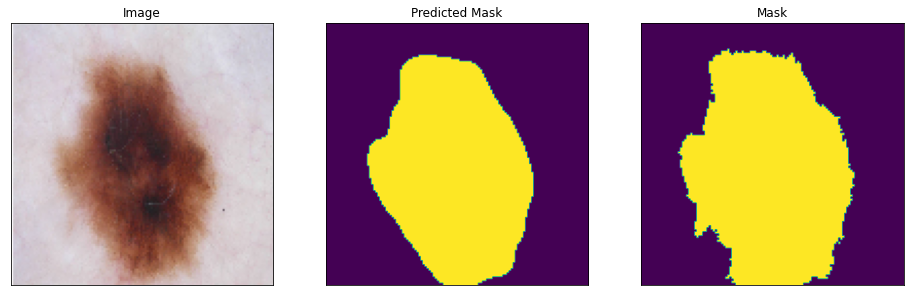

In [9]:
from utils.helper import Visualisation

print(test_image.shape)
output = output.permute(0, 2, 3, 1)

Visualisation().plot_images(
    image=test_image.squeeze(),
    predicted_mask=output.squeeze(axis=0),
    mask=test_masks[index].squeeze()
)

### Calculate Metrics

This metric calculation is based on the [umetrics library](https://github.com/quantumjot/unet_segmentation_metrics).

The calculation uses the jaccard index threshold from the dataset description [landing page](https://challenge2018.isic-archive.com/task1/), section `metrics`, which is `0.65`.

In [10]:
from constants import TEST_DIR
from utils.helper import NotebookHelper

test_images, test_masks = NotebookHelper().load_images(TEST_DIR, load_masks=True, resize_to=(128, 128))
len(test_images)

300

In [11]:
%%time

import numpy as np

predicted_masks_list = []

for test_image in test_images:
    test_image = np.expand_dims(test_image, axis=0)
    test_image = torch.from_numpy(test_image).permute(0, 3, 1, 2)
    output = torch.sigmoid(azure_model(test_image)).cpu().detach()
    output = output.permute(0, 2, 3, 1).numpy()
    predicted_mask = output.round().squeeze(axis=0)
    predicted_masks_list.append(predicted_mask)
    
predicted_masks = np.stack(predicted_masks_list)

assert predicted_masks.shape == (len(test_masks), 128, 128, 1), f"Shape was: {predicted_masks.shape}"

CPU times: user 4min 15s, sys: 29.8 s, total: 4min 45s
Wall time: 2min 43s


In [12]:
%%time

from utils.metrics import Metrics

metrics = Metrics().calculate_batch(
    masks=test_masks,
    predicted_masks=predicted_masks
)

metrics

CPU times: user 13.9 s, sys: 79 ms, total: 14 s
Wall time: 14.3 s


{'n_images': 300,
 'n_true_positives': 934499,
 'n_true_positives_%': 0.8222655132939666,
 'n_true_negatives': 3643355,
 'n_true_negatives_%': 0.9641803399946066,
 'n_false_positives': 135352,
 'n_false_negatives': 201994,
 'iou_score': 0.7321913761037038,
 'threshold_jaccard_index': 0.6401470559493686,
 'jaccard_similarity_index': 0.7321913761037038,
 'dice': 0.8138721899753992,
 'f1_score': 0.4069360949876996,
 'sensitivity': 0.8976937614198939,
 'specificity': 0.9678008121886205,
 'accuracy': 0.9313667805989584}

#### Full Image Resolution Metrics

In [13]:
%%time

from constants import TEST_DIR
from utils.helper import NotebookHelper

full_size_test_images, full_size_test_masks = NotebookHelper().load_images(TEST_DIR, load_masks=True, normalize=False)
print(len(full_size_test_images))

300
CPU times: user 2min, sys: 8.58 s, total: 2min 8s
Wall time: 2min 10s


In [14]:
%%time

import cv2
import numpy as np

full_size_predicted_masks = []

for index, full_size_test_image in enumerate(full_size_test_images):
        height, width = full_size_test_images[index].shape[:-1]
        # scale up predicted mask to original image resolution
        full_size_predicted_mask = cv2.resize(
            src=predicted_masks[index],
            dsize=(width, height),
            interpolation=cv2.INTER_NEAREST
        )
        full_size_predicted_mask = np.expand_dims(full_size_predicted_mask, axis=2)
        
        assert full_size_predicted_mask.shape[:-1] == full_size_test_image.shape[:-1], \
            "upscaled mask has not the same dimension as original image"
        
        full_size_predicted_masks.append(full_size_predicted_mask)

CPU times: user 7.29 s, sys: 16.4 s, total: 23.7 s
Wall time: 7.07 s


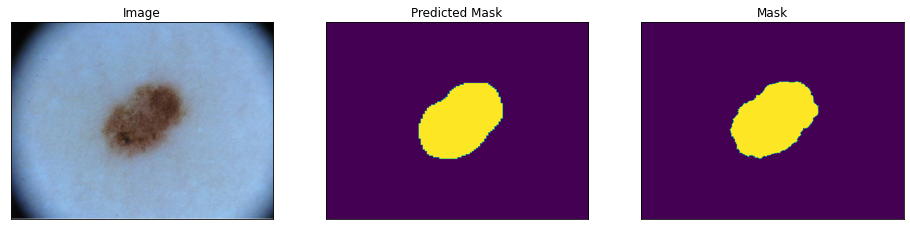

In [15]:
from utils.helper import Visualisation

Visualisation().plot_images(
    image=full_size_test_images[0].squeeze(),
    predicted_mask=full_size_predicted_masks[0],
    mask=full_size_test_masks[0].squeeze()
)

In [16]:
%%time

from utils.metrics import Metrics



metrics = Metrics().calculate_batch(
    masks=full_size_test_masks,
    predicted_masks=[mask * 255.0 for mask in full_size_predicted_masks], # predicted mask comes back normalized
    normalize=True
)

metrics

CPU times: user 58min 46s, sys: 41.5 s, total: 59min 27s
Wall time: 1h 14s


{'n_images': 300,
 'n_true_positives': 525068207,
 'n_true_positives_%': 0.7991043289349222,
 'n_true_negatives': 1882164999,
 'n_true_negatives_%': 0.9638196715512879,
 'n_false_positives': 70653619,
 'n_false_negatives': 132002701,
 'iou_score': 0.7255022216810778,
 'threshold_jaccard_index': 0.6338987835908674,
 'jaccard_similarity_index': 0.7255022216810778,
 'dice': 0.809897563584473,
 'f1_score': 0.4049487817922365,
 'sensitivity': 0.8942938133483502,
 'specificity': 0.967347210647246,
 'accuracy': 0.9306270170083283}

## Experiment 52 - Batch size 16

In [17]:
from constants import EXPORT_DIR
import os

AZURE_PATH = os.path.join(
    EXPORT_DIR, "azure", "2021_05_24_1413", "trans_u_net", "TU_ISIC_128_pretrain_R50-ViT-B_16_skip3_11k_epo40_bs16_128"
)

print(AZURE_PATH)

/Users/jh/ai/courses/stanford/3-ML_RL/final_project/xcs229ii_final_project/code/experiments/export/azure/2021_05_24_1413/trans_u_net/TU_ISIC_128_pretrain_R50-ViT-B_16_skip3_11k_epo40_bs16_128


In [18]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [19]:
from transformers.trans_u_net.backbones.vit_seg_modeling import CONFIGS
from transformers.trans_u_net.backbones.vit_seg_modeling import VisionTransformer

VIT_NAME = "R50-ViT-B_16"
PATCH_SIZE = 16
IMAGE_SIZE = 128
NO_CLASSES = 1
NO_SKIP = 3

config_vit = CONFIGS[VIT_NAME]
config_vit.n_classes = NO_CLASSES
config_vit.n_skip = NO_SKIP
config_vit.patches.size = (PATCH_SIZE, PATCH_SIZE)
config_vit.patches.grid = (int(IMAGE_SIZE / PATCH_SIZE), int(IMAGE_SIZE / PATCH_SIZE))

azure_model = VisionTransformer(config_vit, img_size=IMAGE_SIZE, num_classes=NO_CLASSES).to(device)
snapshot = os.path.join(AZURE_PATH, "latest_epoch_39.pth")
azure_model.load_state_dict(torch.load(snapshot, map_location=torch.device('cpu')))

<All keys matched successfully>

In [20]:
from constants import TEST_DIR
from utils.helper import NotebookHelper

test_images, test_masks = NotebookHelper().load_images(TEST_DIR, load_masks=True, resize_to=(128, 128), size=5)
print(len(test_images))

5


In [21]:
import torch
import numpy as np

index = 4

test_image = test_images[index]
test_image = np.expand_dims(test_image, axis=0)
tensor = torch.from_numpy(test_image).permute(0, 3, 1, 2)
print(tensor.shape)

with torch.no_grad():
    output = azure_model(tensor)
    output = torch.sigmoid(output).round()

print(type(output))

torch.Size([1, 3, 128, 128])
<class 'torch.Tensor'>


(1, 128, 128, 3)


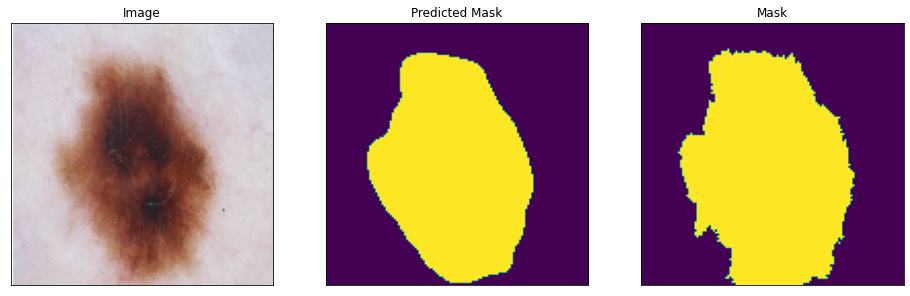

In [22]:
from utils.helper import Visualisation

print(test_image.shape)
output = output.permute(0, 2, 3, 1)

Visualisation().plot_images(
    image=test_image.squeeze(),
    predicted_mask=output.squeeze(axis=0),
    mask=test_masks[index].squeeze()
)

### Calculate Metrics

This metric calculation is based on the [umetrics library](https://github.com/quantumjot/unet_segmentation_metrics).

The calculation uses the jaccard index threshold from the dataset description [landing page](https://challenge2018.isic-archive.com/task1/), section `metrics`, which is `0.65`.

In [23]:
from constants import TEST_DIR
from utils.helper import NotebookHelper

test_images, test_masks = NotebookHelper().load_images(TEST_DIR, load_masks=True, resize_to=(128, 128))
len(test_images)

300

In [24]:
%%time

import numpy as np

predicted_masks_list = []

for test_image in test_images:
    test_image = np.expand_dims(test_image, axis=0)
    test_image = torch.from_numpy(test_image).permute(0, 3, 1, 2)
    output = torch.sigmoid(azure_model(test_image)).cpu().detach()
    output = output.permute(0, 2, 3, 1).numpy()
    predicted_mask = output.round().squeeze(axis=0)
    predicted_masks_list.append(predicted_mask)
    
predicted_masks = np.stack(predicted_masks_list)

assert predicted_masks.shape == (len(test_masks), 128, 128, 1), f"Shape was: {predicted_masks.shape}"

CPU times: user 4min 1s, sys: 26.1 s, total: 4min 27s
Wall time: 2min 28s


In [25]:
%%time

from utils.metrics import Metrics

metrics = Metrics().calculate_batch(
    masks=test_masks,
    predicted_masks=predicted_masks
)

metrics

CPU times: user 13.6 s, sys: 48.4 ms, total: 13.7 s
Wall time: 13.7 s


{'n_images': 300,
 'n_true_positives': 913249,
 'n_true_positives_%': 0.8035676418596507,
 'n_true_negatives': 3664087,
 'n_true_negatives_%': 0.9696668728218409,
 'n_false_positives': 114620,
 'n_false_negatives': 223244,
 'iou_score': 0.7268641708786863,
 'threshold_jaccard_index': 0.6413340542477567,
 'jaccard_similarity_index': 0.7268641708786863,
 'dice': 0.8093671226269004,
 'f1_score': 0.4046835613134502,
 'sensitivity': 0.8827053236409931,
 'specificity': 0.9729878995020659,
 'accuracy': 0.9312613932291667}

#### Full Image Resolution Metrics

In [26]:
%%time

from constants import TEST_DIR
from utils.helper import NotebookHelper

full_size_test_images, full_size_test_masks = NotebookHelper().load_images(TEST_DIR, load_masks=True, normalize=False)
print(len(full_size_test_images))

300
CPU times: user 1min 59s, sys: 8.94 s, total: 2min 8s
Wall time: 2min 8s


In [27]:
%%time

import cv2
import numpy as np

full_size_predicted_masks = []

for index, full_size_test_image in enumerate(full_size_test_images):
        height, width = full_size_test_images[index].shape[:-1]
        # scale up predicted mask to original image resolution
        full_size_predicted_mask = cv2.resize(
            src=predicted_masks[index],
            dsize=(width, height),
            interpolation=cv2.INTER_NEAREST
        )
        full_size_predicted_mask = np.expand_dims(full_size_predicted_mask, axis=2)
        
        assert full_size_predicted_mask.shape[:-1] == full_size_test_image.shape[:-1], \
            "upscaled mask has not the same dimension as original image"
        
        full_size_predicted_masks.append(full_size_predicted_mask)

CPU times: user 7.54 s, sys: 17.9 s, total: 25.4 s
Wall time: 7.65 s


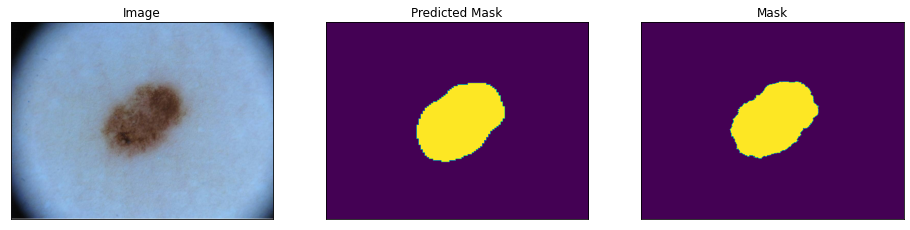

In [28]:
from utils.helper import Visualisation

Visualisation().plot_images(
    image=full_size_test_images[0].squeeze(),
    predicted_mask=full_size_predicted_masks[0],
    mask=full_size_test_masks[0].squeeze()
)

In [29]:
%%time

from utils.metrics import Metrics



metrics = Metrics().calculate_batch(
    masks=full_size_test_masks,
    predicted_masks=[mask * 255.0 for mask in full_size_predicted_masks], # predicted mask comes back normalized
    normalize=True
)

metrics

CPU times: user 1h 51s, sys: 52.2 s, total: 1h 1min 43s
Wall time: 1h 3min 17s


{'n_images': 300,
 'n_true_positives': 513723550,
 'n_true_positives_%': 0.781838830094727,
 'n_true_negatives': 1891275777,
 'n_true_negatives_%': 0.9684851217451881,
 'n_false_positives': 61542841,
 'n_false_negatives': 143347358,
 'iou_score': 0.7215846129443684,
 'threshold_jaccard_index': 0.636778587110814,
 'jaccard_similarity_index': 0.7215846129443684,
 'dice': 0.8060845124842623,
 'f1_score': 0.40304225624213114,
 'sensitivity': 0.8798169323304715,
 'specificity': 0.972544610026719,
 'accuracy': 0.9305620303944742}

## Experiment 53 - Batch size 4

In [30]:
from constants import EXPORT_DIR
import os

AZURE_PATH = os.path.join(
    EXPORT_DIR, "azure", "2021_05_24_2023", "trans_u_net"
)

print(AZURE_PATH)

/Users/jh/ai/courses/stanford/3-ML_RL/final_project/xcs229ii_final_project/code/experiments/export/azure/2021_05_24_2023/trans_u_net


In [31]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [32]:
from transformers.trans_u_net.backbones.vit_seg_modeling import CONFIGS
from transformers.trans_u_net.backbones.vit_seg_modeling import VisionTransformer

VIT_NAME = "R50-ViT-B_16"
PATCH_SIZE = 16
IMAGE_SIZE = 128
NO_CLASSES = 1
NO_SKIP = 3

config_vit = CONFIGS[VIT_NAME]
config_vit.n_classes = NO_CLASSES
config_vit.n_skip = NO_SKIP
config_vit.patches.size = (PATCH_SIZE, PATCH_SIZE)
config_vit.patches.grid = (int(IMAGE_SIZE / PATCH_SIZE), int(IMAGE_SIZE / PATCH_SIZE))

azure_model = VisionTransformer(config_vit, img_size=IMAGE_SIZE, num_classes=NO_CLASSES).to(device)
snapshot = os.path.join(AZURE_PATH, "latest_epoch_39.pth")
azure_model.load_state_dict(torch.load(snapshot, map_location=torch.device('cpu')))

<All keys matched successfully>

In [33]:
from constants import TEST_DIR
from utils.helper import NotebookHelper

test_images, test_masks = NotebookHelper().load_images(TEST_DIR, load_masks=True, resize_to=(128, 128), size=5)
print(len(test_images))

5


In [34]:
import torch
import numpy as np

index = 4

test_image = test_images[index]
test_image = np.expand_dims(test_image, axis=0)
tensor = torch.from_numpy(test_image).permute(0, 3, 1, 2)
print(tensor.shape)

with torch.no_grad():
    output = azure_model(tensor)
    output = torch.sigmoid(output).round()

print(type(output))

torch.Size([1, 3, 128, 128])
<class 'torch.Tensor'>


(1, 128, 128, 3)


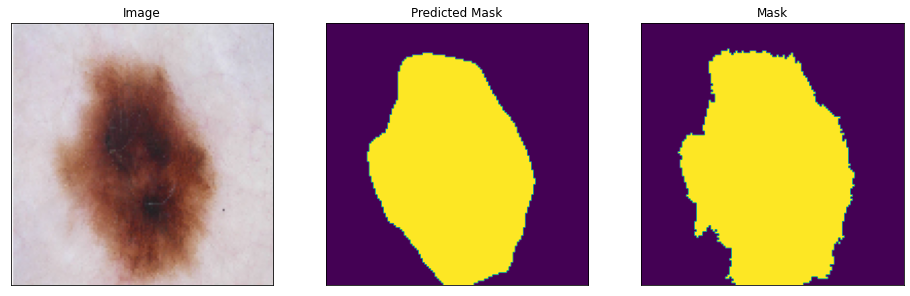

In [35]:
from utils.helper import Visualisation

print(test_image.shape)
output = output.permute(0, 2, 3, 1)

Visualisation().plot_images(
    image=test_image.squeeze(),
    predicted_mask=output.squeeze(axis=0),
    mask=test_masks[index].squeeze()
)

### Calculate Metrics

This metric calculation is based on the [umetrics library](https://github.com/quantumjot/unet_segmentation_metrics).

The calculation uses the jaccard index threshold from the dataset description [landing page](https://challenge2018.isic-archive.com/task1/), section `metrics`, which is `0.65`.

In [36]:
from constants import TEST_DIR
from utils.helper import NotebookHelper

test_images, test_masks = NotebookHelper().load_images(TEST_DIR, load_masks=True, resize_to=(128, 128))
len(test_images)

300

In [37]:
%%time

import numpy as np

predicted_masks_list = []

for test_image in test_images:
    test_image = np.expand_dims(test_image, axis=0)
    test_image = torch.from_numpy(test_image).permute(0, 3, 1, 2)
    output = torch.sigmoid(azure_model(test_image)).cpu().detach()
    output = output.permute(0, 2, 3, 1).numpy()
    predicted_mask = output.round().squeeze(axis=0)
    predicted_masks_list.append(predicted_mask)
    
predicted_masks = np.stack(predicted_masks_list)

assert predicted_masks.shape == (len(test_masks), 128, 128, 1), f"Shape was: {predicted_masks.shape}"

CPU times: user 4min 14s, sys: 28.7 s, total: 4min 43s
Wall time: 2min 42s


In [38]:
%%time

from utils.metrics import Metrics

metrics = Metrics().calculate_batch(
    masks=test_masks,
    predicted_masks=predicted_masks
)

metrics

CPU times: user 14.5 s, sys: 117 ms, total: 14.6 s
Wall time: 14.9 s


{'n_images': 300,
 'n_true_positives': 946939,
 'n_true_positives_%': 0.8332114672065732,
 'n_true_negatives': 3691921,
 'n_true_negatives_%': 0.9770328845290202,
 'n_false_positives': 86786,
 'n_false_negatives': 189554,
 'iou_score': 0.7828304218928748,
 'threshold_jaccard_index': 0.7121017186310928,
 'jaccard_similarity_index': 0.7828304218928748,
 'dice': 0.860442904412219,
 'f1_score': 0.4302214522061095,
 'sensitivity': 0.8877613051819344,
 'specificity': 0.9750993350661533,
 'accuracy': 0.9437784830729167}

#### Full Image Resolution Metrics

In [39]:
%%time

from constants import TEST_DIR
from utils.helper import NotebookHelper

full_size_test_images, full_size_test_masks = NotebookHelper().load_images(TEST_DIR, load_masks=True, normalize=False)
print(len(full_size_test_images))

300
CPU times: user 2min 6s, sys: 9.55 s, total: 2min 16s
Wall time: 2min 21s


In [40]:
%%time

import cv2
import numpy as np

full_size_predicted_masks = []

for index, full_size_test_image in enumerate(full_size_test_images):
        height, width = full_size_test_images[index].shape[:-1]
        # scale up predicted mask to original image resolution
        full_size_predicted_mask = cv2.resize(
            src=predicted_masks[index],
            dsize=(width, height),
            interpolation=cv2.INTER_NEAREST
        )
        full_size_predicted_mask = np.expand_dims(full_size_predicted_mask, axis=2)
        
        assert full_size_predicted_mask.shape[:-1] == full_size_test_image.shape[:-1], \
            "upscaled mask has not the same dimension as original image"
        
        full_size_predicted_masks.append(full_size_predicted_mask)

CPU times: user 7.08 s, sys: 16.7 s, total: 23.8 s
Wall time: 7.1 s


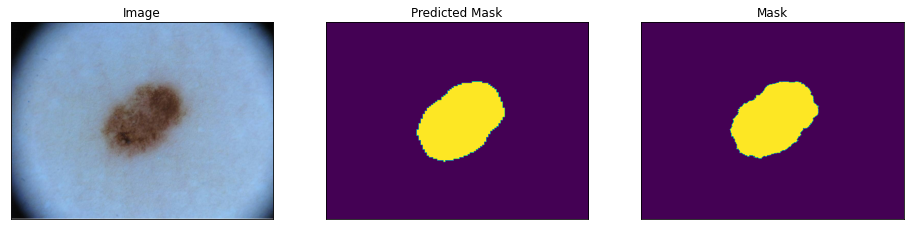

In [41]:
from utils.helper import Visualisation

Visualisation().plot_images(
    image=full_size_test_images[0].squeeze(),
    predicted_mask=full_size_predicted_masks[0],
    mask=full_size_test_masks[0].squeeze()
)

In [42]:
%%time

from utils.metrics import Metrics



metrics = Metrics().calculate_batch(
    masks=full_size_test_masks,
    predicted_masks=[mask * 255.0 for mask in full_size_predicted_masks], # predicted mask comes back normalized
    normalize=True
)

metrics

CPU times: user 59min 54s, sys: 52.9 s, total: 1h 46s
Wall time: 1h 2min 2s


{'n_images': 300,
 'n_true_positives': 539141829,
 'n_true_positives_%': 0.8205230553290604,
 'n_true_negatives': 1902263347,
 'n_true_negatives_%': 0.974111640203545,
 'n_false_positives': 50555271,
 'n_false_negatives': 117929079,
 'iou_score': 0.7747193882462599,
 'threshold_jaccard_index': 0.7042463865352678,
 'jaccard_similarity_index': 0.7747193882462599,
 'dice': 0.8557294788623085,
 'f1_score': 0.4278647394311543,
 'sensitivity': 0.8838947909665588,
 'specificity': 0.9744560056403354,
 'accuracy': 0.9428701158621179}

## Experiment 54 - Adam, Batch size 4

In [43]:
from constants import EXPORT_DIR
import os

AZURE_PATH = os.path.join(
    EXPORT_DIR, "azure", "2021_05_25_0103", "trans_u_net"
)

print(AZURE_PATH)

/Users/jh/ai/courses/stanford/3-ML_RL/final_project/xcs229ii_final_project/code/experiments/export/azure/2021_05_25_0103/trans_u_net


In [44]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [45]:
from transformers.trans_u_net.backbones.vit_seg_modeling import CONFIGS
from transformers.trans_u_net.backbones.vit_seg_modeling import VisionTransformer

VIT_NAME = "R50-ViT-B_16"
PATCH_SIZE = 16
IMAGE_SIZE = 128
NO_CLASSES = 1
NO_SKIP = 3

config_vit = CONFIGS[VIT_NAME]
config_vit.n_classes = NO_CLASSES
config_vit.n_skip = NO_SKIP
config_vit.patches.size = (PATCH_SIZE, PATCH_SIZE)
config_vit.patches.grid = (int(IMAGE_SIZE / PATCH_SIZE), int(IMAGE_SIZE / PATCH_SIZE))

azure_model = VisionTransformer(config_vit, img_size=IMAGE_SIZE, num_classes=NO_CLASSES).to(device)
snapshot = os.path.join(AZURE_PATH, "latest_epoch_39.pth")
azure_model.load_state_dict(torch.load(snapshot, map_location=torch.device('cpu')))

<All keys matched successfully>

In [46]:
from constants import TEST_DIR
from utils.helper import NotebookHelper

test_images, test_masks = NotebookHelper().load_images(TEST_DIR, load_masks=True, resize_to=(128, 128), size=5)
print(len(test_images))

5


In [47]:
import torch
import numpy as np

index = 4

test_image = test_images[index]
test_image = np.expand_dims(test_image, axis=0)
tensor = torch.from_numpy(test_image).permute(0, 3, 1, 2)
print(tensor.shape)

with torch.no_grad():
    output = azure_model(tensor)
    output = torch.sigmoid(output).round()

print(type(output))

torch.Size([1, 3, 128, 128])
<class 'torch.Tensor'>


(1, 128, 128, 3)


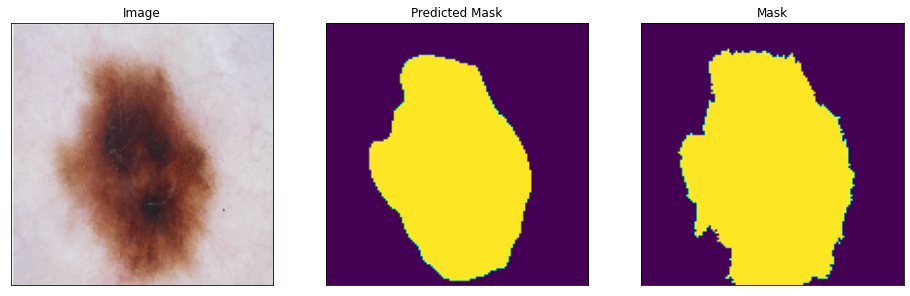

In [48]:
from utils.helper import Visualisation

print(test_image.shape)
output = output.permute(0, 2, 3, 1)

Visualisation().plot_images(
    image=test_image.squeeze(),
    predicted_mask=output.squeeze(axis=0),
    mask=test_masks[index].squeeze()
)

### Calculate Metrics

This metric calculation is based on the [umetrics library](https://github.com/quantumjot/unet_segmentation_metrics).

The calculation uses the jaccard index threshold from the dataset description [landing page](https://challenge2018.isic-archive.com/task1/), section `metrics`, which is `0.65`.

In [49]:
from constants import TEST_DIR
from utils.helper import NotebookHelper

test_images, test_masks = NotebookHelper().load_images(TEST_DIR, load_masks=True, resize_to=(128, 128))
len(test_images)

300

In [50]:
%%time

import numpy as np

predicted_masks_list = []

for test_image in test_images:
    test_image = np.expand_dims(test_image, axis=0)
    test_image = torch.from_numpy(test_image).permute(0, 3, 1, 2)
    output = torch.sigmoid(azure_model(test_image)).cpu().detach()
    output = output.permute(0, 2, 3, 1).numpy()
    predicted_mask = output.round().squeeze(axis=0)
    predicted_masks_list.append(predicted_mask)
    
predicted_masks = np.stack(predicted_masks_list)

assert predicted_masks.shape == (len(test_masks), 128, 128, 1), f"Shape was: {predicted_masks.shape}"

CPU times: user 4min 19s, sys: 29.5 s, total: 4min 48s
Wall time: 2min 46s


In [51]:
%%time

from utils.metrics import Metrics

metrics = Metrics().calculate_batch(
    masks=test_masks,
    predicted_masks=predicted_masks
)

metrics

CPU times: user 14.5 s, sys: 117 ms, total: 14.7 s
Wall time: 15.2 s


{'n_images': 300,
 'n_true_positives': 978324,
 'n_true_positives_%': 0.8608271234402676,
 'n_true_negatives': 3719963,
 'n_true_negatives_%': 0.9844539415202078,
 'n_false_positives': 58744,
 'n_false_negatives': 158169,
 'iou_score': 0.8108016578844206,
 'threshold_jaccard_index': 0.7520887974421043,
 'jaccard_similarity_index': 0.8108016578844206,
 'dice': 0.8832681939016872,
 'f1_score': 0.4416340969508436,
 'sensitivity': 0.888814993749934,
 'specificity': 0.9820297536969566,
 'accuracy': 0.9558689371744792}

#### Full Image Resolution Metrics

In [52]:
%%time

from constants import TEST_DIR
from utils.helper import NotebookHelper

full_size_test_images, full_size_test_masks = NotebookHelper().load_images(TEST_DIR, load_masks=True, normalize=False)
print(len(full_size_test_images))

300
CPU times: user 2min 4s, sys: 9.94 s, total: 2min 14s
Wall time: 2min 19s


In [53]:
%%time

import cv2
import numpy as np

full_size_predicted_masks = []

for index, full_size_test_image in enumerate(full_size_test_images):
        height, width = full_size_test_images[index].shape[:-1]
        # scale up predicted mask to original image resolution
        full_size_predicted_mask = cv2.resize(
            src=predicted_masks[index],
            dsize=(width, height),
            interpolation=cv2.INTER_NEAREST
        )
        full_size_predicted_mask = np.expand_dims(full_size_predicted_mask, axis=2)
        
        assert full_size_predicted_mask.shape[:-1] == full_size_test_image.shape[:-1], \
            "upscaled mask has not the same dimension as original image"
        
        full_size_predicted_masks.append(full_size_predicted_mask)

CPU times: user 7.53 s, sys: 17.2 s, total: 24.7 s
Wall time: 7.32 s


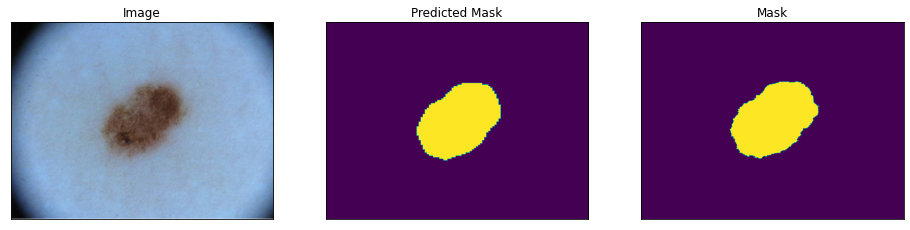

In [54]:
from utils.helper import Visualisation

Visualisation().plot_images(
    image=full_size_test_images[0].squeeze(),
    predicted_mask=full_size_predicted_masks[0],
    mask=full_size_test_masks[0].squeeze()
)

In [55]:
%%time

from utils.metrics import Metrics

metrics = Metrics().calculate_batch(
    masks=full_size_test_masks,
    predicted_masks=[mask * 255.0 for mask in full_size_predicted_masks], # predicted mask comes back normalized
    normalize=True
)

metrics

CPU times: user 58min 23s, sys: 51.5 s, total: 59min 15s
Wall time: 1h 20s


{'n_images': 300,
 'n_true_positives': 560803634,
 'n_true_positives_%': 0.8534902811432948,
 'n_true_negatives': 1921108127,
 'n_true_negatives_%': 0.9837616813421839,
 'n_false_positives': 31710491,
 'n_false_negatives': 96267274,
 'iou_score': 0.8090335807479768,
 'threshold_jaccard_index': 0.7505203616676627,
 'jaccard_similarity_index': 0.8090335807479768,
 'dice': 0.8820973256889577,
 'f1_score': 0.44104866284447886,
 'sensitivity': 0.888524474291288,
 'specificity': 0.981966084824553,
 'accuracy': 0.9557350331484467}

## Experiment 55 - Adam, Batch size 4, Jaccard Loss Only

In [56]:
from constants import EXPORT_DIR
import os

AZURE_PATH = os.path.join(
    EXPORT_DIR, "azure", "2021_05_27_0055", "trans_u_net"
)

print(AZURE_PATH)

/Users/jh/ai/courses/stanford/3-ML_RL/final_project/xcs229ii_final_project/code/experiments/export/azure/2021_05_27_0055/trans_u_net


In [57]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [58]:
from transformers.trans_u_net.backbones.vit_seg_modeling import CONFIGS
from transformers.trans_u_net.backbones.vit_seg_modeling import VisionTransformer

VIT_NAME = "R50-ViT-B_16"
PATCH_SIZE = 16
IMAGE_SIZE = 128
NO_CLASSES = 1
NO_SKIP = 3

config_vit = CONFIGS[VIT_NAME]
config_vit.n_classes = NO_CLASSES
config_vit.n_skip = NO_SKIP
config_vit.patches.size = (PATCH_SIZE, PATCH_SIZE)
config_vit.patches.grid = (int(IMAGE_SIZE / PATCH_SIZE), int(IMAGE_SIZE / PATCH_SIZE))

azure_model = VisionTransformer(config_vit, img_size=IMAGE_SIZE, num_classes=NO_CLASSES).to(device)
snapshot = os.path.join(AZURE_PATH, "latest_epoch_39.pth")
azure_model.load_state_dict(torch.load(snapshot, map_location=torch.device('cpu')))

<All keys matched successfully>

In [59]:
from constants import TEST_DIR
from utils.helper import NotebookHelper

test_images, test_masks = NotebookHelper().load_images(TEST_DIR, load_masks=True, resize_to=(128, 128), size=5)
print(len(test_images))

5


In [60]:
import torch
import numpy as np

index = 4

test_image = test_images[index]
test_image = np.expand_dims(test_image, axis=0)
tensor = torch.from_numpy(test_image).permute(0, 3, 1, 2)
print(tensor.shape)

with torch.no_grad():
    output = azure_model(tensor)
    output = torch.sigmoid(output).round()

print(type(output))

torch.Size([1, 3, 128, 128])
<class 'torch.Tensor'>


(1, 128, 128, 3)


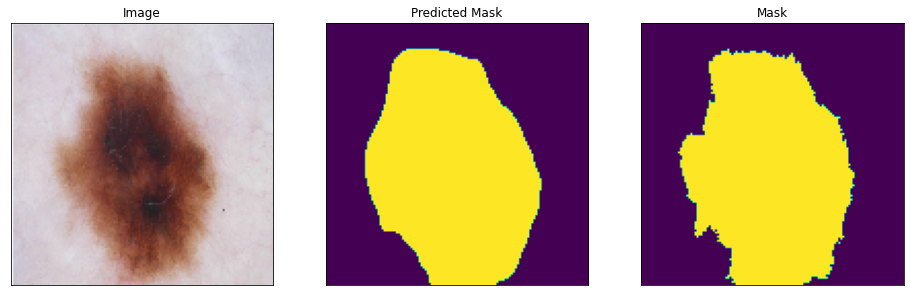

In [61]:
from utils.helper import Visualisation

print(test_image.shape)
output = output.permute(0, 2, 3, 1)

Visualisation().plot_images(
    image=test_image.squeeze(),
    predicted_mask=output.squeeze(axis=0),
    mask=test_masks[index].squeeze()
)

### Calculate Metrics

This metric calculation is based on the [umetrics library](https://github.com/quantumjot/unet_segmentation_metrics).

The calculation uses the jaccard index threshold from the dataset description [landing page](https://challenge2018.isic-archive.com/task1/), section `metrics`, which is `0.65`.

In [62]:
from constants import TEST_DIR
from utils.helper import NotebookHelper

test_images, test_masks = NotebookHelper().load_images(TEST_DIR, load_masks=True, resize_to=(128, 128))
len(test_images)

300

In [63]:
%%time

import numpy as np

predicted_masks_list = []

for test_image in test_images:
    test_image = np.expand_dims(test_image, axis=0)
    test_image = torch.from_numpy(test_image).permute(0, 3, 1, 2)
    output = torch.sigmoid(azure_model(test_image)).cpu().detach()
    output = output.permute(0, 2, 3, 1).numpy()
    predicted_mask = output.round().squeeze(axis=0)
    predicted_masks_list.append(predicted_mask)
    
predicted_masks = np.stack(predicted_masks_list)

assert predicted_masks.shape == (len(test_masks), 128, 128, 1), f"Shape was: {predicted_masks.shape}"

CPU times: user 4min 3s, sys: 28.8 s, total: 4min 32s
Wall time: 2min 32s


In [64]:
%%time

from utils.metrics import Metrics

metrics = Metrics().calculate_batch(
    masks=test_masks,
    predicted_masks=predicted_masks
)

metrics

CPU times: user 13.2 s, sys: 69.9 ms, total: 13.3 s
Wall time: 13.4 s


{'n_images': 300,
 'n_true_positives': 997960,
 'n_true_positives_%': 0.8781048365454077,
 'n_true_negatives': 3682350,
 'n_true_negatives_%': 0.9745000075422625,
 'n_false_positives': 96357,
 'n_false_negatives': 138533,
 'iou_score': 0.8095959384669726,
 'threshold_jaccard_index': 0.7539749051233315,
 'jaccard_similarity_index': 0.8095959384669726,
 'dice': 0.8814244002625325,
 'f1_score': 0.4407122001312663,
 'sensitivity': 0.9038998863944663,
 'specificity': 0.9707719687833236,
 'accuracy': 0.9522115071614583}

#### Full Image Resolution Metrics

In [65]:
%%time

from constants import TEST_DIR
from utils.helper import NotebookHelper

full_size_test_images, full_size_test_masks = NotebookHelper().load_images(TEST_DIR, load_masks=True, normalize=False)
print(len(full_size_test_images))

300
CPU times: user 2min, sys: 9.29 s, total: 2min 9s
Wall time: 2min 11s


In [66]:
%%time

import cv2
import numpy as np

full_size_predicted_masks = []

for index, full_size_test_image in enumerate(full_size_test_images):
        height, width = full_size_test_images[index].shape[:-1]
        # scale up predicted mask to original image resolution
        full_size_predicted_mask = cv2.resize(
            src=predicted_masks[index],
            dsize=(width, height),
            interpolation=cv2.INTER_NEAREST
        )
        full_size_predicted_mask = np.expand_dims(full_size_predicted_mask, axis=2)
        
        assert full_size_predicted_mask.shape[:-1] == full_size_test_image.shape[:-1], \
            "upscaled mask has not the same dimension as original image"
        
        full_size_predicted_masks.append(full_size_predicted_mask)

CPU times: user 7.59 s, sys: 16.3 s, total: 23.9 s
Wall time: 8.26 s


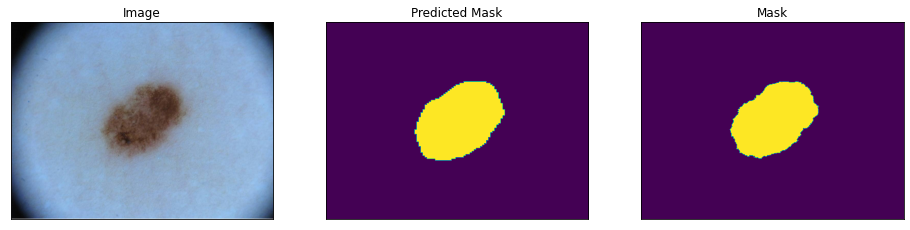

In [67]:
from utils.helper import Visualisation

Visualisation().plot_images(
    image=full_size_test_images[0].squeeze(),
    predicted_mask=full_size_predicted_masks[0],
    mask=full_size_test_masks[0].squeeze()
)

In [68]:
%%time

from utils.metrics import Metrics

metrics = Metrics().calculate_batch(
    masks=full_size_test_masks,
    predicted_masks=[mask * 255.0 for mask in full_size_predicted_masks], # predicted mask comes back normalized
    normalize=True
)

metrics

CPU times: user 55min 52s, sys: 36.5 s, total: 56min 28s
Wall time: 56min 58s


{'n_images': 300,
 'n_true_positives': 573963393,
 'n_true_positives_%': 0.8735181941733449,
 'n_true_negatives': 1898005056,
 'n_true_negatives_%': 0.9719310531481219,
 'n_false_positives': 54813562,
 'n_false_negatives': 83107515,
 'iou_score': 0.8086006237009715,
 'threshold_jaccard_index': 0.7532039551090681,
 'jaccard_similarity_index': 0.8086006237009715,
 'dice': 0.8807972435804368,
 'f1_score': 0.4403986217902184,
 'sensitivity': 0.9042571659665161,
 'specificity': 0.9708095018654209,
 'accuracy': 0.9522356584827159}